In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline 

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Cricket Data Analysis').getOrCreate()

23/11/22 14:11:25 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [3]:
match_info = spark.read.csv('gs://cricket_dbms/notebooks/jupyter/ODI_Match_info.csv', header=True, inferSchema = True)
match_data = spark.read.csv('gs://cricket_dbms/notebooks/jupyter/ODI_Match_Data.csv', header=True, inferSchema = True)

In [4]:
match_info.show(5)

+-------+-------+----------+----------+-----------+----------+-----------+-------------+------+----------+-----------+-----------+--------------+---------------+--------------------+--------------------+---------------+--------------------+
|     id| season|      city|      date|      team1|     team2|toss_winner|toss_decision|result|dl_applied|     winner|win_by_runs|win_by_wickets|player_of_match|               venue|             umpire1|        umpire2|             umpire3|
+-------+-------+----------+----------+-----------+----------+-----------+-------------+------+----------+-----------+-----------+--------------+---------------+--------------------+--------------------+---------------+--------------------+
|1389389|2023/24|    Indore|2023/09/24|      India| Australia|  Australia|        field|   D/L|         1|      India|         99|             0|        SS Iyer|Holkar Cricket St...|       J Madanagopal|HDPK Dharmasena|KN Ananthapadmana...|
|1336129|   2023|Nottingham|2023/09/

In [5]:
match_data.show(5)

+--------+-------+-------------------+--------------------+-------+----+------------+------------+----------+------------+----------+------------+------+-----+-------+----+-------+-------+-----------+----------------+-----------------+----------------------+------------+
|match_id| season|         start_date|               venue|innings|ball|batting_team|bowling_team|   striker| non_striker|    bowler|runs_off_bat|extras|wides|noballs|byes|legbyes|penalty|wicket_type|player_dismissed|other_wicket_type|other_player_dismissed|cricsheet_id|
+--------+-------+-------------------+--------------------+-------+----+------------+------------+----------+------------+----------+------------+------+-----+-------+----+-------+-------+-----------+----------------+-----------------+----------------------+------------+
| 1389389|2023/24|2023-09-24 00:00:00|Holkar Cricket St...|      1| 0.1|       India|   Australia|RD Gaikwad|Shubman Gill|SH Johnson|           4|     0| null|   null|null|   null|   n

In [6]:
#checking for missing values
from pyspark.sql.functions import col,isnan,when,count
missing_df = match_info.select([count(when(col(c).contains('None') | col(c).contains('NULL') | (col(c) == '') | col(c).isNull() | isnan(c), c )).alias(c)
                    for c in match_info.columns])
missing_df.show()

+---+------+----+----+-----+-----+-----------+-------------+------+----------+------+-----------+--------------+---------------+-----+-------+-------+-------+
| id|season|city|date|team1|team2|toss_winner|toss_decision|result|dl_applied|winner|win_by_runs|win_by_wickets|player_of_match|venue|umpire1|umpire2|umpire3|
+---+------+----+----+-----+-----+-----------+-------------+------+----------+------+-----------+--------------+---------------+-----+-------+-------+-------+
|  0|     0| 310|   0|    0|    0|          0|            0|     0|         0|   120|          0|             0|            151|    0|      0|      0|    282|
+---+------+----+----+-----+-----+-----------+-------------+------+----------+------+-----------+--------------+---------------+-----+-------+-------+-------+



In [7]:
#droping for missing values
drop_null_all = match_info.dropna(how ='any')
drop_null_all.show(5)

+-------+-------+----------+----------+-----------+----------+-----------+-------------+------+----------+-----------+-----------+--------------+---------------+--------------------+--------------------+---------------+--------------------+
|     id| season|      city|      date|      team1|     team2|toss_winner|toss_decision|result|dl_applied|     winner|win_by_runs|win_by_wickets|player_of_match|               venue|             umpire1|        umpire2|             umpire3|
+-------+-------+----------+----------+-----------+----------+-----------+-------------+------+----------+-----------+-----------+--------------+---------------+--------------------+--------------------+---------------+--------------------+
|1389389|2023/24|    Indore|2023/09/24|      India| Australia|  Australia|        field|   D/L|         1|      India|         99|             0|        SS Iyer|Holkar Cricket St...|       J Madanagopal|HDPK Dharmasena|KN Ananthapadmana...|
|1336129|   2023|Nottingham|2023/09/

In [8]:
#checking duplicates
duplicate_records = match_info.exceptAll(match_info.dropDuplicates())
duplicate_records.show()

+---+------+----+----+-----+-----+-----------+-------------+------+----------+------+-----------+--------------+---------------+-----+-------+-------+-------+
| id|season|city|date|team1|team2|toss_winner|toss_decision|result|dl_applied|winner|win_by_runs|win_by_wickets|player_of_match|venue|umpire1|umpire2|umpire3|
+---+------+----+----+-----+-----+-----------+-------------+------+----------+------+-----------+--------------+---------------+-----+-------+-------+-------+
+---+------+----+----+-----+-----+-----------+-------------+------+----------+------+-----------+--------------+---------------+-----+-------+-------+-------+



In [9]:
#checking duplicates
duplicate_records = match_data.exceptAll(match_data.dropDuplicates())
duplicate_records.show()

+--------+-------+-------------------+--------------------+-------+----+------------+------------+----------------+-----------------+--------------+------------+------+-----+-------+----+-------+-------+-----------+----------------+-----------------+----------------------+------------+
|match_id| season|         start_date|               venue|innings|ball|batting_team|bowling_team|         striker|      non_striker|        bowler|runs_off_bat|extras|wides|noballs|byes|legbyes|penalty|wicket_type|player_dismissed|other_wicket_type|other_player_dismissed|cricsheet_id|
+--------+-------+-------------------+--------------------+-------+----+------------+------------+----------------+-----------------+--------------+------------+------+-----+-------+----+-------+-------+-----------+----------------+-----------------+----------------------+------------+
|  325803|2007/08|2008-01-30 00:00:00|       Iqbal Stadium|      1| 4.1|    Zimbabwe|    Pakistan|     SC Williams|      H Masakadza| Sohai

In [10]:
#remove the duplicates
match_data = match_data.dropDuplicates()
match_data.show(5)

+--------+-------+-------------------+--------------------+-------+----+------------+------------+------------+-------------+-----------------+------------+------+-----+-------+----+-------+-------+-----------+----------------+-----------------+----------------------+------------+
|match_id| season|         start_date|               venue|innings|ball|batting_team|bowling_team|     striker|  non_striker|           bowler|runs_off_bat|extras|wides|noballs|byes|legbyes|penalty|wicket_type|player_dismissed|other_wicket_type|other_player_dismissed|cricsheet_id|
+--------+-------+-------------------+--------------------+-------+----+------------+------------+------------+-------------+-----------------+------------+------+-----+-------+----+-------+-------+-----------+----------------+-----------------+----------------------+------------+
| 1389389|2023/24|2023-09-24 00:00:00|Holkar Cricket St...|      1|10.1|       India|   Australia|Shubman Gill|      SS Iyer|          A Zampa|           

In [11]:
#checking data types
match_info.dtypes

[('id', 'int'),
 ('season', 'string'),
 ('city', 'string'),
 ('date', 'string'),
 ('team1', 'string'),
 ('team2', 'string'),
 ('toss_winner', 'string'),
 ('toss_decision', 'string'),
 ('result', 'string'),
 ('dl_applied', 'int'),
 ('winner', 'string'),
 ('win_by_runs', 'int'),
 ('win_by_wickets', 'int'),
 ('player_of_match', 'string'),
 ('venue', 'string'),
 ('umpire1', 'string'),
 ('umpire2', 'string'),
 ('umpire3', 'string')]

In [12]:
match_info.show(5)

+-------+-------+----------+----------+-----------+----------+-----------+-------------+------+----------+-----------+-----------+--------------+---------------+--------------------+--------------------+---------------+--------------------+
|     id| season|      city|      date|      team1|     team2|toss_winner|toss_decision|result|dl_applied|     winner|win_by_runs|win_by_wickets|player_of_match|               venue|             umpire1|        umpire2|             umpire3|
+-------+-------+----------+----------+-----------+----------+-----------+-------------+------+----------+-----------+-----------+--------------+---------------+--------------------+--------------------+---------------+--------------------+
|1389389|2023/24|    Indore|2023/09/24|      India| Australia|  Australia|        field|   D/L|         1|      India|         99|             0|        SS Iyer|Holkar Cricket St...|       J Madanagopal|HDPK Dharmasena|KN Ananthapadmana...|
|1336129|   2023|Nottingham|2023/09/

In [13]:
#converting date columns into datetime
from pyspark.sql.functions import *

match_info = match_info.withColumn("date", to_date(col("date"),"yyyy/MM/dd").alias("date"))

#checking data types
match_info.dtypes

[('id', 'int'),
 ('season', 'string'),
 ('city', 'string'),
 ('date', 'date'),
 ('team1', 'string'),
 ('team2', 'string'),
 ('toss_winner', 'string'),
 ('toss_decision', 'string'),
 ('result', 'string'),
 ('dl_applied', 'int'),
 ('winner', 'string'),
 ('win_by_runs', 'int'),
 ('win_by_wickets', 'int'),
 ('player_of_match', 'string'),
 ('venue', 'string'),
 ('umpire1', 'string'),
 ('umpire2', 'string'),
 ('umpire3', 'string')]

In [14]:
match_data.dtypes

[('match_id', 'int'),
 ('season', 'string'),
 ('start_date', 'timestamp'),
 ('venue', 'string'),
 ('innings', 'int'),
 ('ball', 'double'),
 ('batting_team', 'string'),
 ('bowling_team', 'string'),
 ('striker', 'string'),
 ('non_striker', 'string'),
 ('bowler', 'string'),
 ('runs_off_bat', 'int'),
 ('extras', 'int'),
 ('wides', 'double'),
 ('noballs', 'double'),
 ('byes', 'double'),
 ('legbyes', 'double'),
 ('penalty', 'double'),
 ('wicket_type', 'string'),
 ('player_dismissed', 'string'),
 ('other_wicket_type', 'string'),
 ('other_player_dismissed', 'string'),
 ('cricsheet_id', 'int')]

In [15]:
#converting date coluumns into datetime
from pyspark.sql.functions import *

match_data = match_data.withColumn("start_date", to_date(col("start_date"),"yyyy-MM-dd").alias("start_date"))

#checking data types
match_data.dtypes

[('match_id', 'int'),
 ('season', 'string'),
 ('start_date', 'date'),
 ('venue', 'string'),
 ('innings', 'int'),
 ('ball', 'double'),
 ('batting_team', 'string'),
 ('bowling_team', 'string'),
 ('striker', 'string'),
 ('non_striker', 'string'),
 ('bowler', 'string'),
 ('runs_off_bat', 'int'),
 ('extras', 'int'),
 ('wides', 'double'),
 ('noballs', 'double'),
 ('byes', 'double'),
 ('legbyes', 'double'),
 ('penalty', 'double'),
 ('wicket_type', 'string'),
 ('player_dismissed', 'string'),
 ('other_wicket_type', 'string'),
 ('other_player_dismissed', 'string'),
 ('cricsheet_id', 'int')]

In [16]:
#basic statistics
match_data.describe().show()

+-------+-----------------+------------------+--------------------+------------------+------------------+------------+------------+-----------------+-----------------+--------------+------------------+-------------------+------------------+-------------------+------------------+------------------+-------+-----------+-----------------+-----------------+----------------------+-----------------+
|summary|         match_id|            season|               venue|           innings|              ball|batting_team|bowling_team|          striker|      non_striker|        bowler|      runs_off_bat|             extras|             wides|            noballs|              byes|           legbyes|penalty|wicket_type| player_dismissed|other_wicket_type|other_player_dismissed|     cricsheet_id|
+-------+-----------------+------------------+--------------------+------------------+------------------+------------+------------+-----------------+-----------------+--------------+------------------+-------

In [17]:
#basic statistics
match_info.describe().show()

+-------+-----------------+------------------+--------+-----------+-----------+-----------+-------------+------+-------------------+-----------+-----------------+------------------+---------------+--------------------+----------+-------------+-----------+
|summary|               id|            season|    city|      team1|      team2|toss_winner|toss_decision|result|         dl_applied|     winner|      win_by_runs|    win_by_wickets|player_of_match|               venue|   umpire1|      umpire2|    umpire3|
+-------+-----------------+------------------+--------+-----------+-----------+-----------+-------------+------+-------------------+-----------+-----------------+------------------+---------------+--------------------+----------+-------------+-----------+
|  count|             2379|              2379|    2069|       2379|       2379|       2379|         2379|  2379|               2379|       2259|             2379|              2379|           2228|                2379|      2379|   

In [18]:
#exploring categorical columns
match_info.groupBy('team1').count().sort('count', ascending=False).show()

+--------------------+-----+
|               team1|count|
+--------------------+-----+
|           Australia|  254|
|               India|  252|
|             England|  225|
|           Sri Lanka|  192|
|          Bangladesh|  191|
|         New Zealand|  182|
|         West Indies|  172|
|        South Africa|  172|
|            Zimbabwe|  144|
|            Pakistan|  139|
|             Ireland|   83|
|         Afghanistan|   66|
|            Scotland|   50|
|United Arab Emirates|   47|
|         Netherlands|   26|
|               Kenya|   25|
|              Canada|   24|
|             Namibia|   23|
|    Papua New Guinea|   23|
|                Oman|   22|
+--------------------+-----+
only showing top 20 rows



In [19]:
match_info.groupBy('city').count().sort('count', ascending=False).show()

+------------+-----+
|        city|count|
+------------+-----+
|        null|  310|
|      Mirpur|   89|
|     Colombo|   87|
|      London|   83|
|    Bulawayo|   63|
|      Harare|   57|
|   Abu Dhabi|   45|
|       Dubai|   44|
|   Centurion|   44|
|      Dublin|   38|
|Johannesburg|   34|
|  Birmingham|   32|
| Southampton|   31|
|    Brisbane|   29|
|    Windhoek|   28|
|      Durban|   28|
|    Auckland|   28|
|      Lahore|   28|
|     Karachi|   27|
|       Perth|   27|
+------------+-----+
only showing top 20 rows



(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42]),
 [Text(0, 0, '2023/24'),
  Text(1, 0, '2023'),
  Text(2, 0, '2022/23'),
  Text(3, 0, '2022'),
  Text(4, 0, '2021/22'),
  Text(5, 0, '2021'),
  Text(6, 0, '2020/21'),
  Text(7, 0, '2020'),
  Text(8, 0, '2019/20'),
  Text(9, 0, '2019'),
  Text(10, 0, '2018/19'),
  Text(11, 0, '2018'),
  Text(12, 0, '2017/18'),
  Text(13, 0, '2017'),
  Text(14, 0, '2016/17'),
  Text(15, 0, '2016'),
  Text(16, 0, '2015/16'),
  Text(17, 0, '2015'),
  Text(18, 0, '2014/15'),
  Text(19, 0, '2014'),
  Text(20, 0, '2013/14'),
  Text(21, 0, '2013'),
  Text(22, 0, '2012/13'),
  Text(23, 0, '2012'),
  Text(24, 0, '2011/12'),
  Text(25, 0, '2011'),
  Text(26, 0, '2010/11'),
  Text(27, 0, '2010'),
  Text(28, 0, '2009/10'),
  Text(29, 0, '2009'),
  Text(30, 0, '2008/09'),
  Text(31, 0, '2008'),
  Text(32, 0, '2007/08'),
  

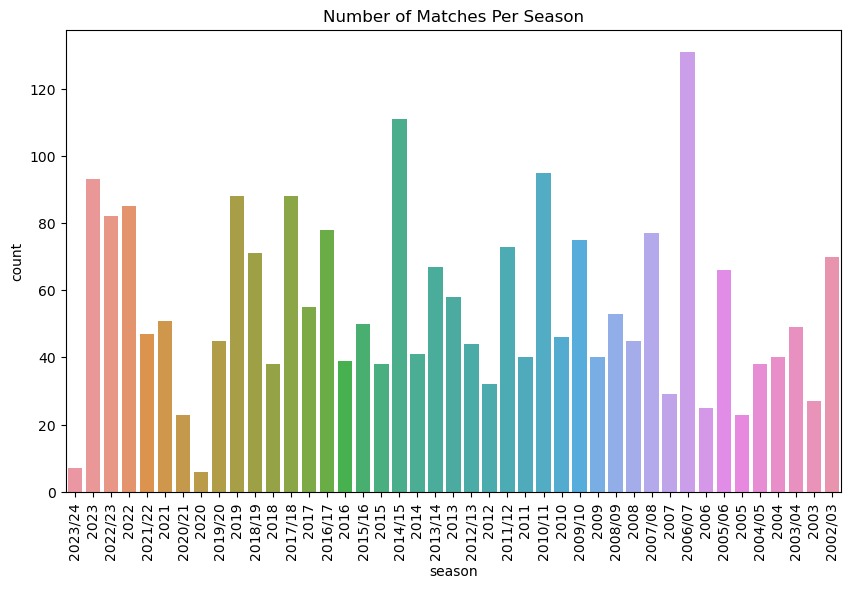

In [20]:
plt.figure(figsize=(10,6))
sns.countplot(x='season', data=match_info.toPandas())
plt.title('Number of Matches Per Season')
plt.xticks(rotation=90)

In [21]:
matches_per_season = match_info.groupBy('season').count().sort('season', ascending=True)
matches_per_season.show(5)

+-------+-----+
| season|count|
+-------+-----+
|2002/03|   70|
|   2003|   27|
|2003/04|   49|
|   2004|   40|
|2004/05|   38|
+-------+-----+
only showing top 5 rows



([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, 

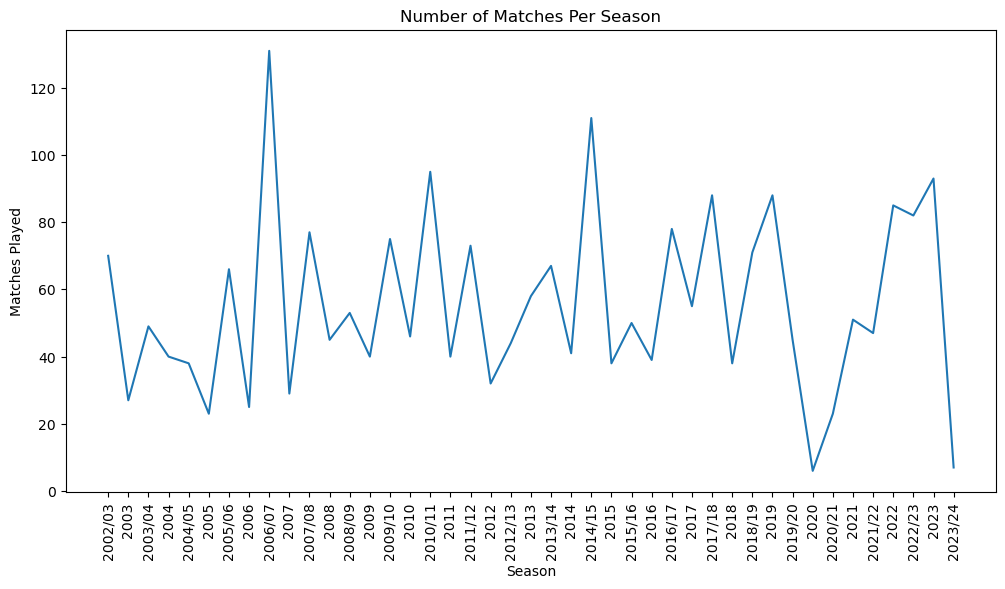

In [22]:
plt.figure(figsize=(12,6))
sns.lineplot(data=matches_per_season.toPandas(), x='season', y='count')
plt.title('Number of Matches Per Season')
plt.xlabel('Season')
plt.ylabel('Matches Played')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 [Text(0, 0, 'India'),
  Text(1, 0, 'Australia'),
  Text(2, 0, 'Sri Lanka'),
  Text(3, 0, 'South Africa'),
  Text(4, 0, 'England'),
  Text(5, 0, 'Pakistan'),
  Text(6, 0, 'New Zealand'),
  Text(7, 0, 'West Indies'),
  Text(8, 0, 'Bangladesh'),
  Text(9, 0, 'Zimbabwe'),
  Text(10, 0, 'Afghanistan'),
  Text(11, 0, 'Ireland'),
  Text(12, 0, 'Scotland'),
  Text(13, 0, 'United Arab Emirates'),
  Text(14, 0, 'Nepal'),
  Text(15, 0, 'Oman'),
  Text(16, 0, 'United States of America'),
  Text(17, 0, 'Namibia'),
  Text(18, 0, 'Netherlands'),
  Text(19, 0, 'Kenya'),
  Text(20, 0, 'Papua New Guinea'),
  Text(21, 0, 'Canada'),
  Text(22, 0, 'Hong Kong'),
  Text(23, 0, 'Asia XI'),
  Text(24, 0, 'Bermuda'),
  Text(25, 0, 'Jersey'),
  Text(26, 0, 'Africa XI')])

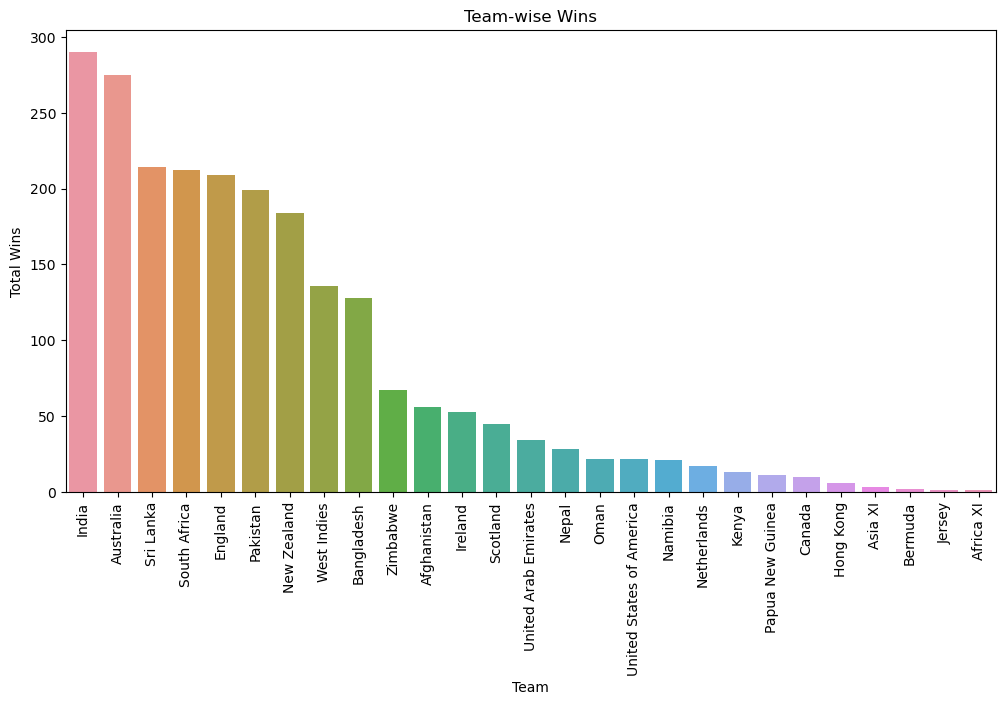

In [23]:
#calculation wins per team
team_wins = match_info.groupBy('winner').count().sort('count', ascending=False)

#plot the data
plt.figure(figsize=(12,6))
sns.barplot(data=team_wins.toPandas(), x='winner', y='count')
plt.title('Team-wise Wins')
plt.xlabel('Team')
plt.ylabel('Total Wins')
plt.xticks(rotation=90)

Text(0, 0.5, 'Venue')

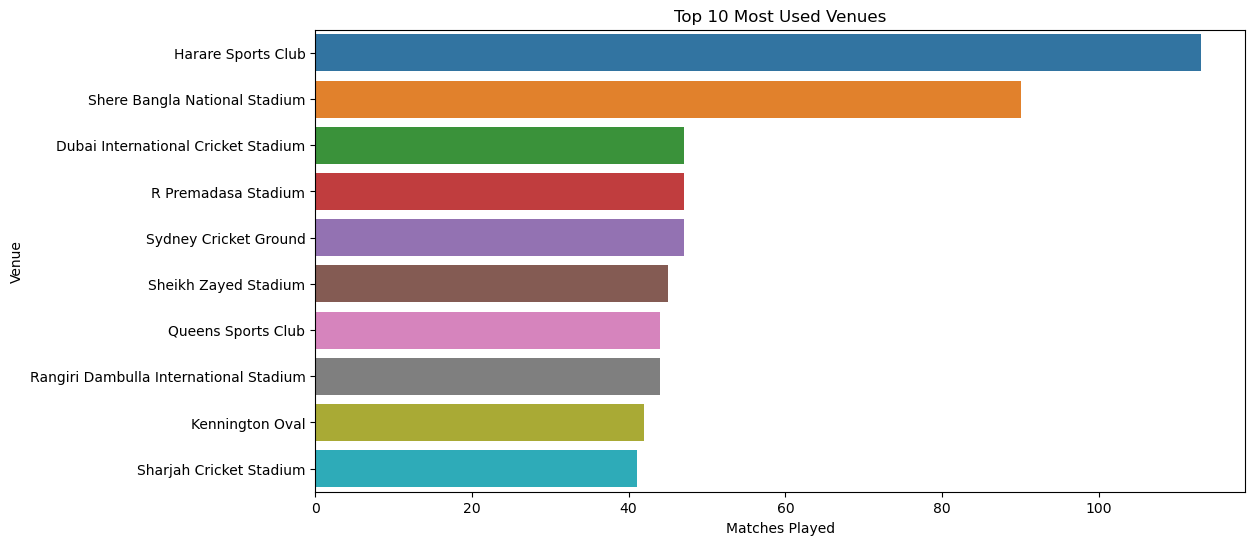

In [24]:
#most frequent used venues
top_venues = match_info.groupBy('venue').count().sort('count', ascending=False).limit(10)

#plot the data
plt.figure(figsize=(12,6))
sns.barplot(data=top_venues.toPandas(), x='count', y='venue')
plt.title('Top 10 Most Used Venues')
plt.xlabel('Matches Played')
plt.ylabel('Venue')

Text(0, 0.5, 'Players')

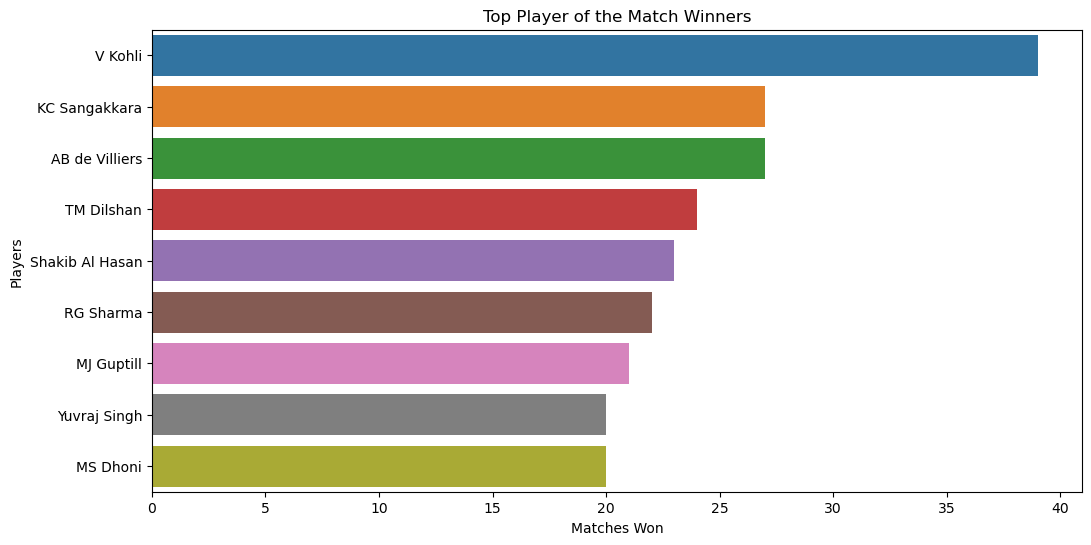

In [25]:
#top player of the match winners
top_players = match_info.groupBy('player_of_match').count().sort('count', ascending=False).limit(10)

#plot the data
plt.figure(figsize=(12,6))
sns.barplot(data=top_players.toPandas(), x='count', y='player_of_match')
plt.title('Top Player of the Match Winners')
plt.xlabel('Matches Won')
plt.ylabel('Players')

Text(0, 0.5, 'Frequency')

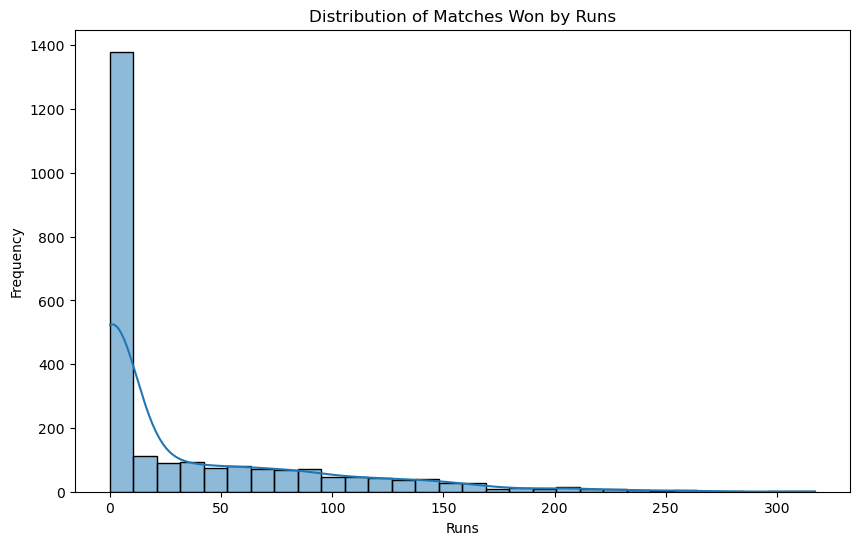

In [26]:
#match outcomes
plt.figure(figsize=(10,6))
sns.histplot(data= match_info.toPandas(), x = 'win_by_runs', bins=30, kde=True)
plt.title('Distribution of Matches Won by Runs')
plt.xlabel('Runs')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

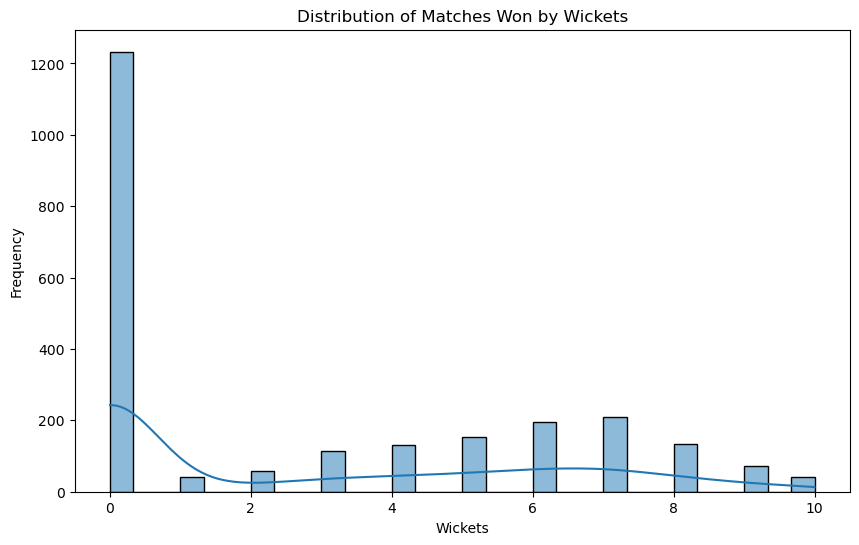

In [27]:
plt.figure(figsize=(10,6))
sns.histplot(data= match_info.toPandas(), x = 'win_by_wickets', bins=30, kde=True)
plt.title('Distribution of Matches Won by Wickets')
plt.xlabel('Wickets')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

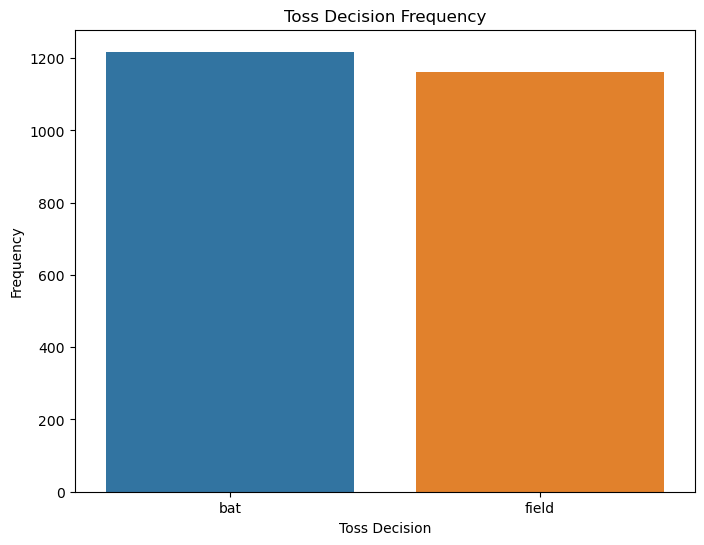

In [28]:
#toss decision 
toss_decision = match_info.groupBy('toss_decision').count().sort('count', ascending=False)

#plot the data
plt.figure(figsize=(8,6))
sns.barplot(data=toss_decision.toPandas(), x='toss_decision', y='count')
plt.title('Toss Decision Frequency')
plt.xlabel('Toss Decision')
plt.ylabel('Frequency')

In [29]:
from pyspark.ml.linalg import DenseMatrix, Vectors
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

In [30]:
numerical_cols = [col[0] for col in match_info.dtypes if col[1] in ['int', 'float']]
match_info_numerical = match_info.select(numerical_cols)

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=match_info_numerical.columns, outputCol=vector_col)
df_vector = assembler.transform(match_info_numerical).select(vector_col)

# correlation will be in Dense Matrix
correlation = Correlation.corr(df_vector, vector_col, "pearson").collect()[0][0]

# To convert Dense Matrix into DataFrame
rows = correlation.toArray().tolist()
df = spark.createDataFrame(rows, numerical_cols)

pdf = df.toPandas()
pdf

,id,dl_applied,win_by_runs,win_by_wickets
0,1.000000,-0.007345,0.006960,-0.028621
1,-0.007345,1.000000,-0.030402,-0.017222
2,0.006960,-0.030402,1.000000,-0.545805
3,-0.028621,-0.017222,-0.545805,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

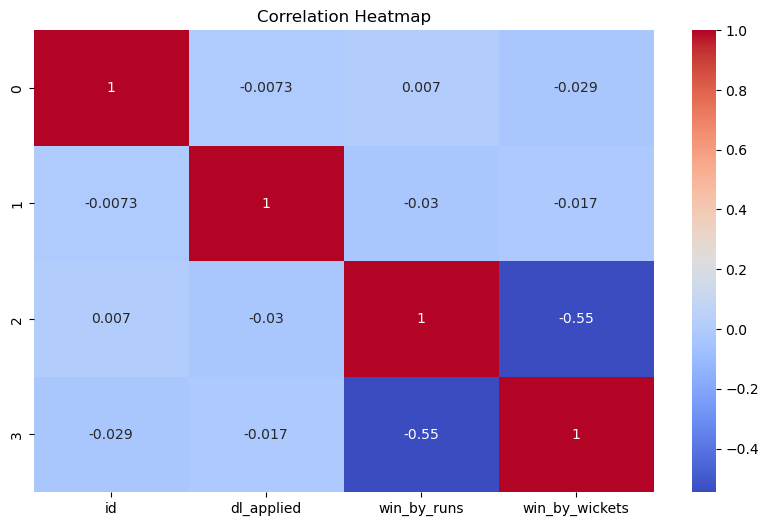

In [31]:
plt.figure(figsize=(10,6))
sns.heatmap(pdf, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')

In [32]:
from pyspark.sql.functions import sum,avg,max
batsmen_total_runs = match_data.groupBy("striker").agg(sum("runs_off_bat").alias("sum_runs_off_bat")).sort('sum_runs_off_bat', ascending=False).limit(10)
batsmen_total_runs.show()

+----------------+----------------+
|         striker|sum_runs_off_bat|
+----------------+----------------+
|         V Kohli|           13027|
|   KC Sangakkara|           11701|
|        MS Dhoni|           10310|
|       RG Sharma|            9961|
|  AB de Villiers|            9435|
|      TM Dilshan|            9212|
|     LRPL Taylor|            8198|
|DPMD Jayawardene|            8154|
|     Tamim Iqbal|            7964|
|         HM Amla|            7875|
+----------------+----------------+



Text(0, 0.5, 'Batsman')

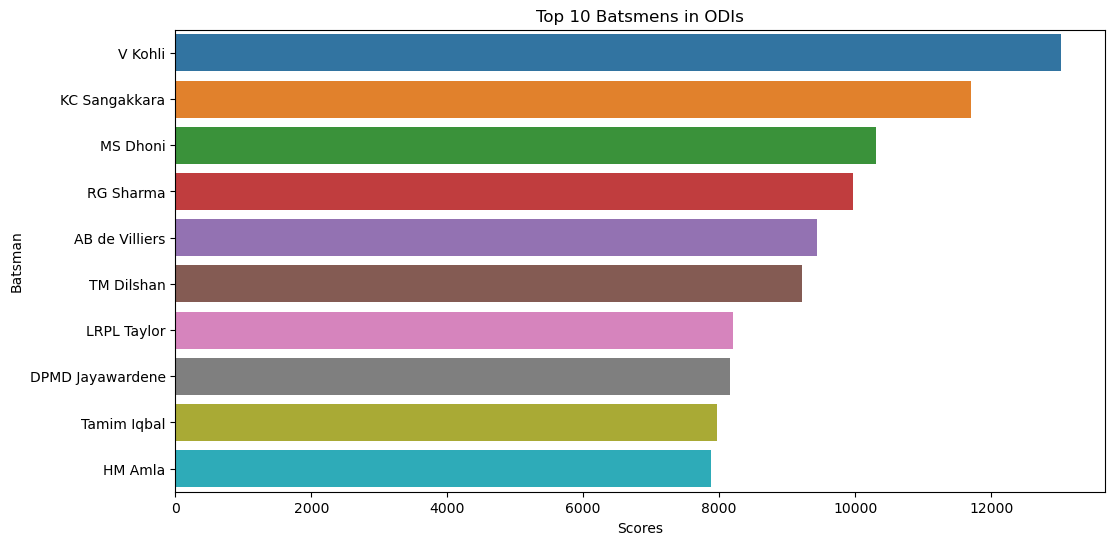

In [33]:
from pyspark.sql.functions import sum,avg,max

#identifying top 10 run scorers
batsmen_total_runs = match_data.groupBy("striker").agg(sum("runs_off_bat").alias("sum")).sort('sum', ascending=False).limit(10)

#plot the data
plt.figure(figsize=(12,6))
sns.barplot(data = batsmen_total_runs.toPandas(), x='sum', y='striker')
plt.title('Top 10 Batsmens in ODIs')
plt.xlabel('Scores')
plt.ylabel('Batsman')

Text(0, 0.5, 'Bowler')

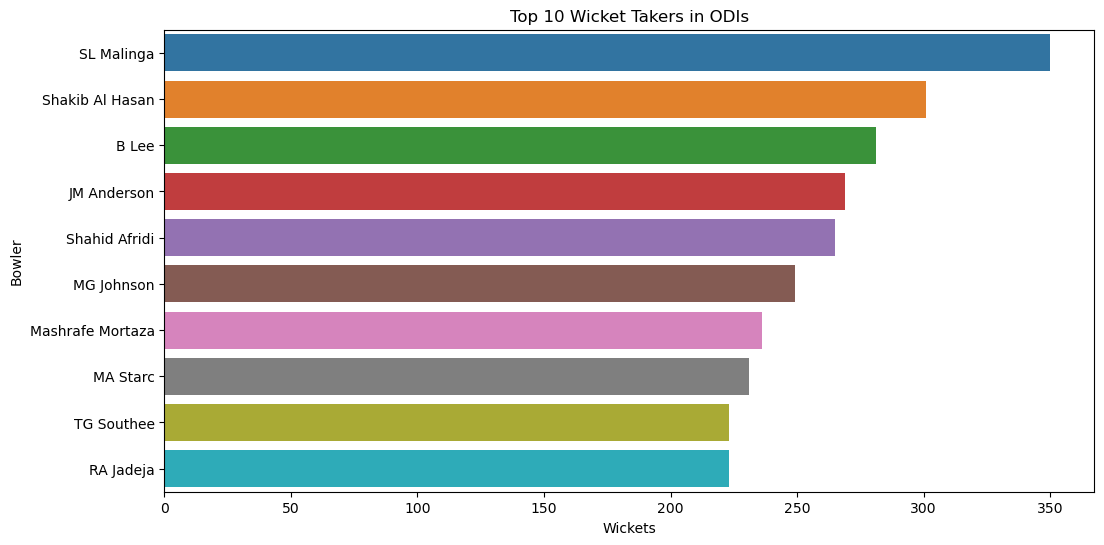

In [34]:
from pyspark.sql.functions import sum,avg,max

# filter the not null wicket_type data
not_null_wicket_type = match_data.na.drop(subset=["wicket_type"])

#identifying top 10 wicket takers
top_bowlers_wickets = not_null_wicket_type.groupBy("bowler").agg(count("wicket_type").alias("count")).sort('count', ascending=False).limit(10)

#plot the data
plt.figure(figsize=(12,6))
sns.barplot(data = top_bowlers_wickets.toPandas(), x='count', y='bowler')
plt.title('Top 10 Wicket Takers in ODIs')
plt.xlabel('Wickets')
plt.ylabel('Bowler')

In [35]:
#top 10 run-scorers and wicket-takers
top_10_batsmen = batsmen_total_runs.select('striker')
top_10_bowlers = top_bowlers_wickets.select('bowler')

In [36]:
top_10_batsmen.show()

+----------------+
|         striker|
+----------------+
|         V Kohli|
|   KC Sangakkara|
|        MS Dhoni|
|       RG Sharma|
|  AB de Villiers|
|      TM Dilshan|
|     LRPL Taylor|
|DPMD Jayawardene|
|     Tamim Iqbal|
|         HM Amla|
+----------------+



In [37]:
top_10_bowlers.show()

+----------------+
|          bowler|
+----------------+
|      SL Malinga|
| Shakib Al Hasan|
|           B Lee|
|     JM Anderson|
|   Shahid Afridi|
|      MG Johnson|
|Mashrafe Mortaza|
|        MA Starc|
|      TG Southee|
|       RA Jadeja|
+----------------+



In [38]:
#extracting nationalities of to 10 batsmen and bowlers
match_data_top_10_batsmen = match_data.join(top_10_batsmen, match_data.striker ==  top_10_batsmen.striker, "leftsemi")
match_data_top_10_bowlers = match_data.join(top_10_bowlers, match_data.bowler ==  top_10_bowlers.bowler, "leftsemi")

nationalities_batsmen = match_data_top_10_batsmen.groupBy(['striker', 'batting_team']).agg(count("batting_team").alias("count")).sort('count', ascending=False)
nationalities_bowlers = match_data_top_10_bowlers.groupBy(['bowler', 'bowling_team']).agg(count("bowling_team").alias("count")).sort('count', ascending=False)

In [39]:
nationalities_batsmen.show()

+----------------+------------+-----+
|         striker|batting_team|count|
+----------------+------------+-----+
|   KC Sangakkara|   Sri Lanka|14594|
|         V Kohli|       India|14157|
|        MS Dhoni|       India|12017|
|       RG Sharma|       India|11247|
|      TM Dilshan|   Sri Lanka|10778|
|     Tamim Iqbal|  Bangladesh|10419|
|DPMD Jayawardene|   Sri Lanka|10148|
|     LRPL Taylor| New Zealand|10134|
|  AB de Villiers|South Africa| 9388|
|         HM Amla|South Africa| 9141|
|DPMD Jayawardene|     Asia XI|  217|
|        MS Dhoni|     Asia XI|  142|
|  AB de Villiers|   Africa XI|  100|
|   KC Sangakkara|     Asia XI|   94|
|   KC Sangakkara|ICC World XI|   62|
+----------------+------------+-----+



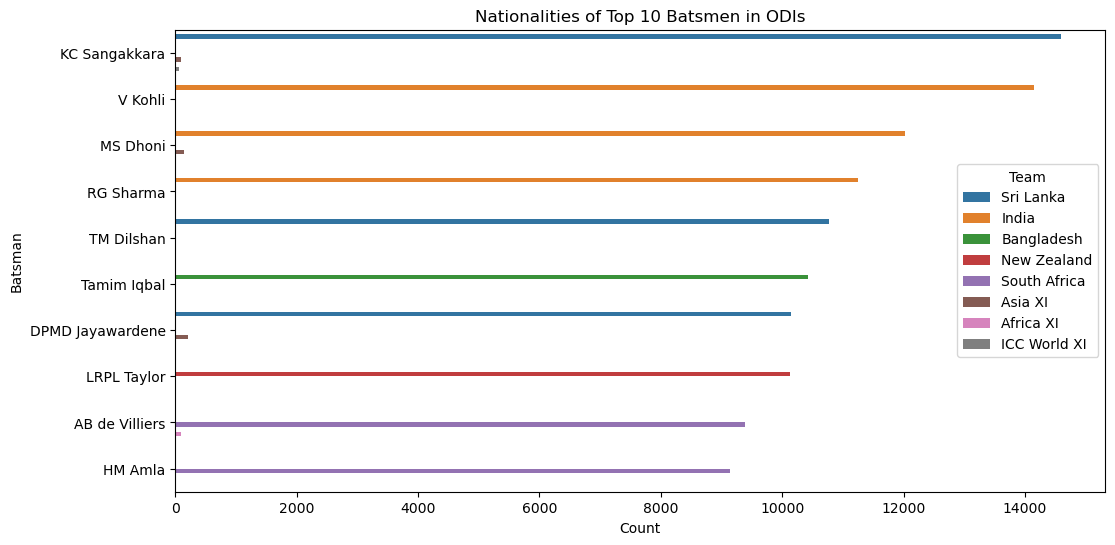

In [40]:
plt.figure(figsize=(12,6))
sns.barplot(x='count', y='striker', hue='batting_team', data=nationalities_batsmen.toPandas())
plt.title('Nationalities of Top 10 Batsmen in ODIs')
plt.xlabel('Count')
plt.ylabel('Batsman')
plt.legend(title='Team', loc='best')

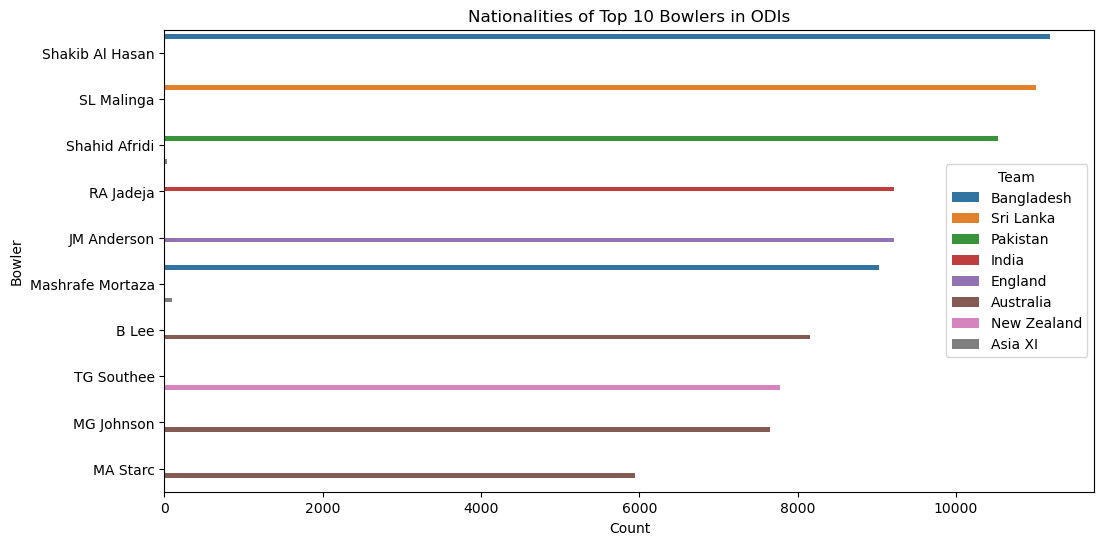

In [41]:
plt.figure(figsize=(12,6))
sns.barplot(x='count', y='bowler', hue='bowling_team', data=nationalities_bowlers.toPandas())
plt.title('Nationalities of Top 10 Bowlers in ODIs')
plt.xlabel('Count')
plt.ylabel('Bowler')
plt.legend(title='Team', loc='best')

In [42]:
#list of team rivarlies (for example: india vs pakistan, australia vs england)
team_rivarlies = [('India', 'Pakistan'), ('Australia', 'England')]

In [43]:
#initializing a dictionary to store head-to-head performances
rivarly_performance = {}

In [44]:
#calculating win-loss records for each rivarly
for team1, team2 in team_rivarlies:
    #filtering matches where team1 played against team2
    head_to_head_matches = match_info[((match_info['team1'] == team1) & (match_info['team2'] == team2)) | 
                                      ((match_info['team1'] == team2) & (match_info['team2'] == team1))]
    #calculating wins for each team
    team1_wins = head_to_head_matches[head_to_head_matches['winner'] == team1].count()
    team2_wins = head_to_head_matches[head_to_head_matches['winner'] == team2].count()
    #storing the performance 
    rivarly_performance[f'{team1} vs {team2}'] = {'Wins': [team1_wins, team2_wins]} 

In [45]:
#creating a dataframe for visualization
rivarly_df = pd.DataFrame(rivarly_performance).T

In [46]:
#extracting the number of wins for team1 and team2
rivarly_df['Team1 Wins'] = rivarly_df['Wins'].apply(lambda x: x[0])
rivarly_df['Team2 Wins'] = rivarly_df['Wins'].apply(lambda x: x[1])

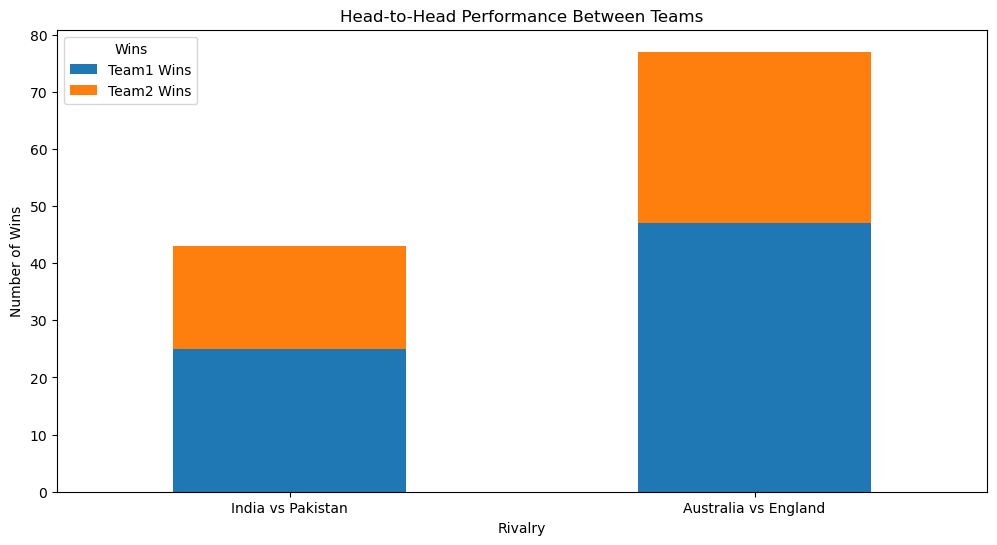

In [47]:
rivarly_df[['Team1 Wins', 'Team2 Wins']].plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Head-to-Head Performance Between Teams')
plt.xlabel('Rivalry')
plt.ylabel('Number of Wins')
plt.xticks(rotation=0)
plt.legend(title='Wins', loc='best')

In [48]:
#extracting columns for toss decision and winner 
toss_decision = match_info.select('toss_decision')
winner = match_info.select('winner')

In [49]:
#calculating win percentages fo different toss decisions
import pyspark.sql.functions as F
total_matches = toss_decision.count()
bat_wins = match_info.filter('toss_decision == "bat"').withColumn('flag', F.when((F.col("winner") == F.col("team1")), 1).otherwise(2)).filter('flag == 1').count()
field_wins = match_info.filter('toss_decision == "field"').withColumn('flag', F.when((F.col("winner") == F.col("team2")), 1).otherwise(2)).filter('flag == 1').count()

In [50]:
bat_win_percentage = (bat_wins / total_matches) * 100
field_win_percentage = (field_wins / total_matches) * 100

Text(0, 0.5, 'Win Percentage')

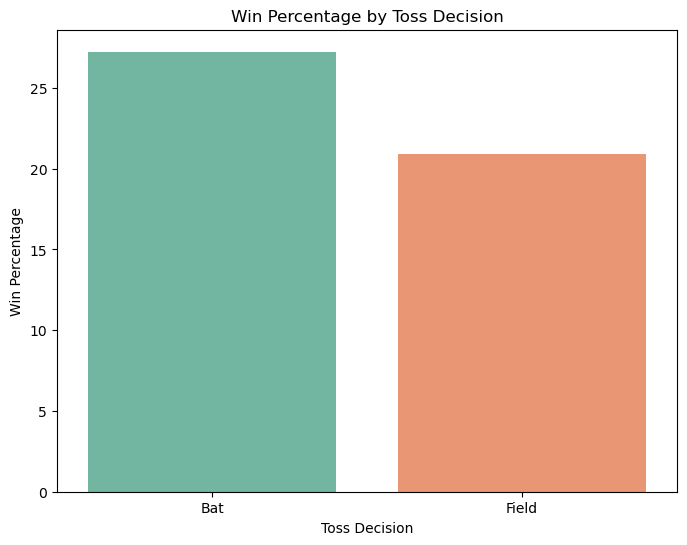

In [51]:
plt.figure(figsize=(8,6))
sns.barplot(x=['Bat','Field'], y=[bat_win_percentage, field_win_percentage], palette='Set2')
plt.title('Win Percentage by Toss Decision')
plt.xlabel('Toss Decision')
plt.ylabel('Win Percentage')

In [52]:
#extracting relevant columns: date, venue, result
selected_columns = ['id', 'date', 'venue', 'result']

In [53]:
#creating a subset of the dataset with the selected columns
subset_data = match_info.select(selected_columns)
subset_data.show()

+-------+----------+--------------------+------+
|     id|      date|               venue|result|
+-------+----------+--------------------+------+
|1389389|2023-09-24|Holkar Cricket St...|   D/L|
|1336129|2023-09-23|Trent Bridge, Not...|normal|
|1395701|2023-09-23|Shere Bangla Nati...|normal|
|1389388|2023-09-22|Punjab Cricket As...|normal|
|1395700|2023-09-21|Shere Bangla Nati...|normal|
|1388414|2023-09-17|R Premadasa Stadi...|normal|
|1373575|2023-09-17|The Wanderers Sta...|normal|
|1388412|2023-09-15|R Premadasa Stadi...|normal|
|1336055|2023-09-15|      Lord's, London|normal|
|1373574|2023-09-15|SuperSport Park, ...|normal|
|1388410|2023-09-14|R Premadasa Stadi...|   D/L|
|1336054|2023-09-13|Kennington Oval, ...|normal|
|1373573|2023-09-12|Sedgars Park, Pot...|normal|
|1388407|2023-09-12|R Premadasa Stadi...|normal|
|1388406|2023-09-11|R Premadasa Stadi...|normal|
|1336053|2023-09-10|The Rose Bowl, So...|normal|
|1373572|2023-09-09|Mangaung Oval, Bl...|normal|
|1388403|2023-09-09|

In [54]:
#converting date columns into datetime
from pyspark.sql.functions import *
subset_data = subset_data.withColumn("date", to_date(col("date"),"yyyy-MM-dd").alias("date"))

In [55]:
#calculating match duration in hours 
import pyspark.sql.functions as funcs
from pyspark.sql.window import Window

window = Window.orderBy(col('date').desc())
subset_data_res = subset_data.withColumn("match_duration_hours", funcs.datediff(funcs.lag(subset_data.date, -1).over(window), subset_data.date) * 24)

23/11/22 14:16:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/22 14:16:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/22 14:16:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/22 14:16:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/22 14:16:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Text(0, 0.5, 'Frequency')

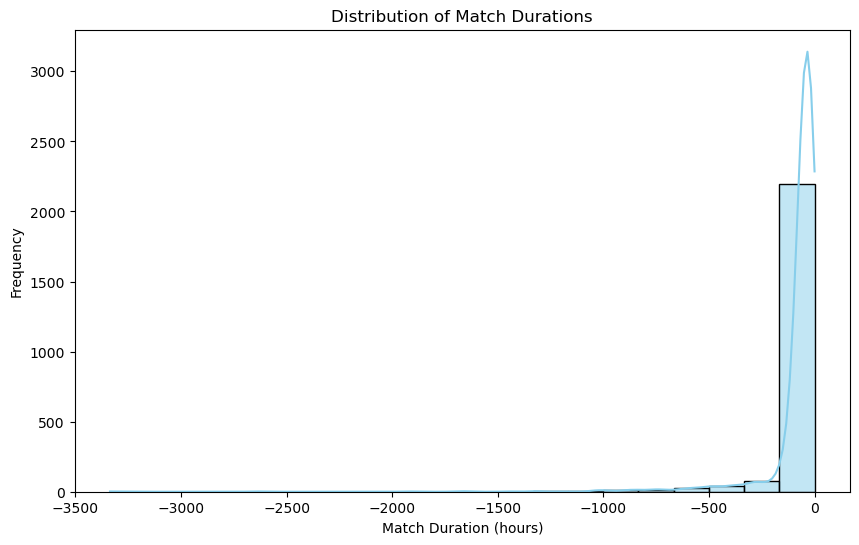

In [56]:
plt.figure(figsize=(10, 6))
sns.histplot(data = subset_data_res.toPandas(), x = "match_duration_hours", bins=20, kde=True, color='skyblue')
plt.title('Distribution of Match Durations')
plt.xlabel('Match Duration (hours)')
plt.ylabel('Frequency')